In [88]:
# Python classics
import numpy as np
import tensorly as tl
import mu_ntd.algorithms.Sparse_ntd as SNTD
import matplotlib.pyplot as plt
import nn_fac.beta_divergence as beta_div

In [89]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Data generation
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
U_lines = 100
V_lines = 101
W_lines = 20
ranks = [4,6,5]
# Noise level
sigma = 1e-2
tol = 0 #running all iterations
# Generation of the input data tensor T
factors_0 = []
#factors_0.append(np.random.rand(U_lines, ranks[0]))
#factors_0.append(np.random.rand(V_lines, ranks[1]))
#factors_0.append(np.random.rand(W_lines, ranks[2]))
# sparse generation
W = np.random.randn(U_lines, ranks[0])
H = np.random.randn(V_lines, ranks[1])
Q = np.random.randn(W_lines, ranks[2])
W[W<0]=0
H[H<0]=0
Q[Q<0]=0
factors_0.append(W)
factors_0.append(H)
factors_0.append(Q)
core_0 = np.random.randn(ranks[0], ranks[1], ranks[2])
core_0[core_0<0]=0 #sparsifying the gt solution
factors_GT = factors_0
core_GT = core_0
T = tl.tenalg.multi_mode_dot(core_0, factors_0) + sigma * np.random.rand(U_lines, V_lines, W_lines) #1e-2

In [90]:
# Random initialization for the NTD
factors_init = []
factors_init.append(np.random.rand(U_lines, ranks[0]))
factors_init.append(np.random.rand(V_lines, ranks[1]))
factors_init.append(np.random.rand(W_lines, ranks[2]))
core_init = np.random.rand(ranks[0], ranks[1], ranks[2])

In [93]:
# Solver parameters
n_iter_max = 200
beta = 0
iter_inner = 3
l2weight = np.array([50, 50, 50, 0])  #(\mu_W, \mu_H, \mu_Q, \mu_g) #use big values for l2weights to ensure better conditioning on polynomial equation: np.array([0, 50, 50, 50])
l1weight = np.array([0, 0, 0, 20])  #(\mu_W, \mu_H, \mu_Q, \mu_g)   #np.array([20, 0, 0, 0]) 

In [92]:
    #------------------------------
    # Call of solvers
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


    # ### Beta = 0 - MU no extrapolation
    core, factors, cost_fct_vals, toc, alpha = SNTD.sntd_mu(T, ranks, l2weights=l2weight, l1weights=l1weight, init = "custom", core_0 = core_init, factors_0 = factors_init, n_iter_max = n_iter_max, tol=tol, beta = beta,
                                                fixed_modes = [], normalize = 4*[None], verbose = False, return_costs = True, extrapolate=False, iter_inner=iter_inner)

100%|██████████| 200/200 [00:39<00:00,  5.03it/s]


In [94]:
    # ### Beta = 0 - MU extrapolation
    core_HER, factors_HER, cost_fct_vals_HER, toc_HER, alpha_HER = SNTD.sntd_mu(T, ranks, l2weights=l2weight, l1weights=l1weight, init = "custom", core_0 = core_init, factors_0 = factors_init, n_iter_max = n_iter_max, tol=tol, beta = beta,
                                                fixed_modes = [], normalize = 4*[None], verbose = False, return_costs = True, extrapolate=True, iter_inner=iter_inner)

100%|██████████| 200/200 [00:39<00:00,  5.13it/s]


In [95]:
    #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Reporting
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("-----------------------------------------------------------------------")
print("Reporting results:")
print("-----------------------------------------------------------------------")
print("Final loss function value:")
print(f"MU, Beta = {beta}       : {cost_fct_vals[-1]}, converged in {len(cost_fct_vals) - 1} iterations.")
print(f"MU - HER, Beta = {beta} : {cost_fct_vals_HER[-1]}, converged in {len(cost_fct_vals_HER) - 1} iterations.")
print("-----------------------------------------------------------------------")
print("Final relative construction error:")
print(f"MU, Beta = {beta}       : {tl.norm(T-tl.tenalg.multi_mode_dot(core, factors))/tl.norm(T)*100} %")
print(f"MU - HER, Beta = {beta} : {tl.norm(T-tl.tenalg.multi_mode_dot(core_HER, factors_HER))/tl.norm(T)*100} %")

-----------------------------------------------------------------------
Reporting results:
-----------------------------------------------------------------------
Final loss function value:
MU, Beta = 0       : 39579.611918084156, converged in 200 iterations.
MU - HER, Beta = 0 : 38969.2176551502, converged in 200 iterations.
-----------------------------------------------------------------------
Final relative construction error:
MU, Beta = 0       : 21.171573659025874 %
MU - HER, Beta = 0 : 18.78804688521136 %


In [96]:
tl.norm(core,order=2, axis=None)


14.607857966643929

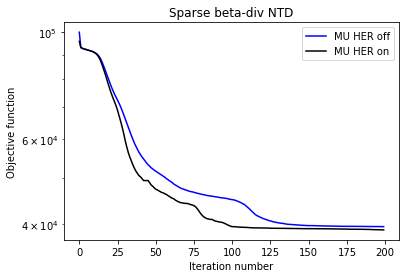

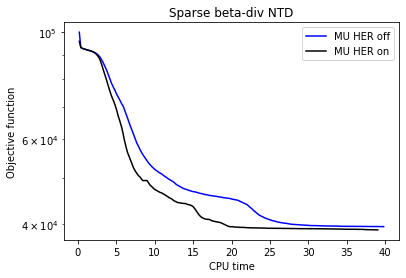

In [97]:
# first iteration shown?
it1 = 1

plt.figure(1)
plt.semilogy(cost_fct_vals[it1:], color='blue', label='MU HER off')
plt.semilogy(cost_fct_vals_HER[it1:], color='black', label='MU HER on')
plt.xlabel('Iteration number')
plt.ylabel('Objective function')
plt.title('Sparse beta-div NTD')
plt.legend()
plt.show()

plt.figure(2)
plt.semilogy(toc[it1:],cost_fct_vals[it1:], color='blue', label='MU HER off')
plt.semilogy(toc_HER[it1:],cost_fct_vals_HER[it1:], color='black', label='MU HER on')
plt.xlabel('CPU time')
plt.ylabel('Objective function')
plt.title('Sparse beta-div NTD')
plt.legend()
plt.show()

In [98]:
# beta-divergence
beta_div.beta_divergence(T, tl.tenalg.multi_mode_dot(core, factors), beta)

31942.299579098977

In [99]:
l1weight[0]*tl.norm(core,1)

1322.4499917105743

In [100]:
l1weight[1]*tl.norm(factors[0],1)

0.0

In [101]:
l1weight[2]*tl.norm(factors[1],1)

0.0

In [102]:
l1weight[3]*tl.norm(factors[2],1)

0.0

In [103]:
1/2*l2weight[0]*tl.norm(core)**2

0.0

In [104]:
1/2*l2weight[1]*tl.norm(factors[0])**2

2098.2112408702938

In [105]:
1/2*l2weight[2]*tl.norm(factors[1])**2

2100.11769912797

In [106]:
1/2*l2weight[3]*tl.norm(factors[2])**2

2099.9057035794294